In [1]:
import os
import time
from datetime import datetime
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

from model_bias_metrics import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
vocab = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
races_used = ['White', 'Latino_Hispanic', 'Black', 'Middle Eastern', 'East Asian']
genders_used = ['Male', 'Female']

In [4]:
bias_types = (
    [('representational', 'gender',      'Exp. 1, rep. bias (gender)')] +     
    [('stereo-happy', 'gender',          'Exp. 2, stereo. bias (gender)')] + 
    [('multistereo-sa-female', 'gender', 'Exp. 3, multiclass stereo. bias (gender)')] +
    [('representational-white', 'race',  'Exp. 1, rep. bias (race)')] + 
    [('stereo-h-white', 'race',          'Exp. 2, stereo. bias (race)')] +  
    [('multistereo-sa-white', 'race',    'Exp. 3, multiclass stereo. bias (race)')]
)

## Bias calculation

In [5]:
measured_bias = {}

for bt, baxis, bname in bias_types:
    databiases = {}
    biases = {}
    recalls = {}
    recallsf = {}
    recallsm = {}
        
    for f in np.arange(0, 1.1, 0.1):
        bias_for_cfg = {}

        model_bias_for_cfg = {}
        
        for r in ([0, 1, 2] if baxis == 'gender' else [0, 1, 2, 4, 5]):

            model_bias_for_cfg[r] = {}
            
            modelname = f'{bt}-f{f:.1f}-r{r}'
            res = pd.read_csv(f'evaluation_results/{modelname}.csv')

            if baxis == 'race':
                res = res[res['race'].isin(races_used)]

            model_bias_for_cfg[r][r'Error'] = 1 - sklearn.metrics.accuracy_score(res['y_true'], res['y_pred'])

            model_bias_for_cfg[r]['Overall Disparity'] = overall_disparity(res[baxis], res['y_true'], res['y_pred'], vocab, np.mean)

            cves = []
            sdes = []
            for g in res[baxis].unique():
                cves.append(combined_error_variance(res[res[baxis] == g], res, vocab))
                sdes.append(symmetric_distance_error(res[res[baxis] == g], res, vocab))
            model_bias_for_cfg[r]['Combined Error Variance'] = np.mean(cves)
            model_bias_for_cfg[r]['Symmetric Distance Error'] = np.mean(sdes)
            

            groups_used = races_used if baxis == 'race' else genders_used
            model_bias_for_cfg[r]['Term-by-term Multiclass Equalized Odds'] = ttm_eq_odds(res, baxis, groups_used)
            model_bias_for_cfg[r]['Classwise Multiclass Equalized Odds'] = cm_eq_odds(res, baxis, groups_used)
            model_bias_for_cfg[r]['Multiclass Equality of Opportunity'] = m_eq_opportunity(res, baxis, groups_used)
            model_bias_for_cfg[r]['Multiclass Demographic Parity'] = m_dem_parity(res, baxis, groups_used)
            
        model_bias_for_cfg = pd.DataFrame(model_bias_for_cfg).mean(1).to_dict()
        bias_for_cfg.update(model_bias_for_cfg)
        
        measured_bias[(bname, f)] = bias_for_cfg

measured_bias_df = pd.DataFrame(measured_bias)

## Figure generation

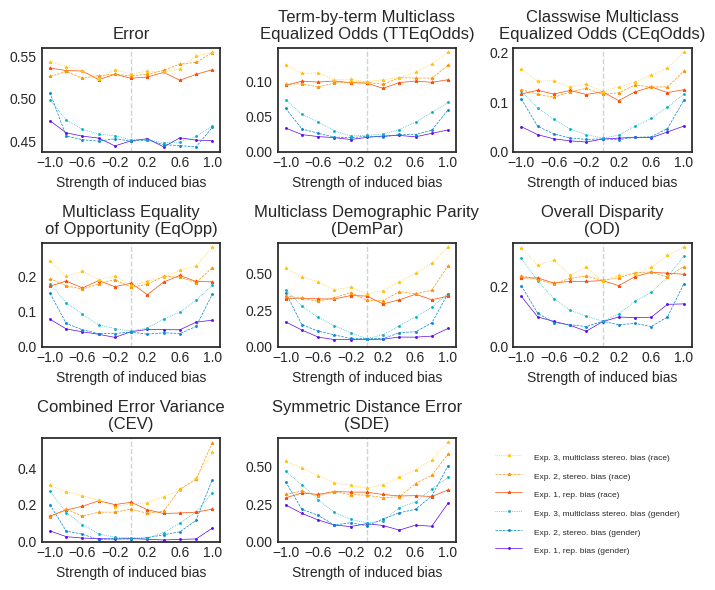

In [6]:
sns.set('paper')
sns.set_style("white")
sns.reset_defaults()

plt.style.use('seaborn-v0_8-bright')

skip_recalls = True

def escape_metric_name(x):
    return (x.replace('$', '').replace(' / ', '-').replace('\\text', '').replace('{', '').replace('}', ''))

plt.close()
sns.set('paper')
sns.set_style("white")
sns.reset_defaults()

plt.style.use('seaborn-v0_8-bright')

# setMatPlotLib('latex')

plt.style.use('seaborn-v0_8-white')

markers = [".",".",".",(5,2),(5,2),(5,2)]

colors = [
    'xkcd:blue/purple',# 'xkcd:cornflower blue',
    'xkcd:cerulean',
    'xkcd:turquoise blue', #'xkcd:azure',
    'xkcd:blood orange',
    'xkcd:tangerine',
    'xkcd:sunflower',
]

linestyles = [
    '-',
    '--',
    ':',
    '-',
    '--',
    ':',
]

fig, axes = plt.subplots(3,3, figsize=(7.14,6))
axes = axes.flatten()

def add_abbreviation(x):
    abbs = {'Term-by-term Multiclass Equalized Odds': '\n(TTEqOdds)',
        'Classwise Multiclass Equalized Odds': '\n(CEqOdds)',
        'Multiclass Equality of Opportunity': '\n(EqOpp)',
        'Multiclass Demographic Parity': '\n(DemPar)',
        'Overall Disparity': '\n(OD)',
        'Combined Error Variance': '\n(CEV)',
        'Symmetric Distance Error': '\n(SDE)'}
    if x in abbs:
        return x+abbs[x]
    else:
        return x

lines = []
for i, metric in enumerate([r'Error',
    'Term-by-term Multiclass Equalized Odds',
    'Classwise Multiclass Equalized Odds',
    'Multiclass Equality of Opportunity',
    'Multiclass Demographic Parity',
    'Overall Disparity',
    'Combined Error Variance',
    'Symmetric Distance Error']):
    ax = axes[i]
    df = measured_bias_df.loc[metric].unstack().T
    lines = []
    for col, m, color, ls in zip([b[-1] for b in bias_types], markers, colors, linestyles):
        if col.startswith("stereo-") and col != "stereo-happy":
            continue
        if all(df[col].isnull()):
            lines.append(ax.plot(np.linspace(-1, 1, 11), df[col], color=color, label=None)) # This just cycles the colors
        else:
            msize = 3 if m =='.' else 2.5
            lines.append(ax.plot(np.linspace(-1, 1, 11), df[col], color=color, ls=ls, label=col, linewidth=0.5, 
                                 marker=m, markeredgewidth = 0.5, markersize=msize))
            
    if len(metric.split()) < 4:
        metricn = add_abbreviation(metric)
        axes[i].set_title(metricn)
    else:
        metricn = add_abbreviation(metric)
        axes[i].set_title(' '.join(metricn.split()[:2]) + '\n' + ' '.join(metricn.split()[2:]))
    axes[i].set_xlabel('Strength of induced bias')
    ax.set_xticks(minor=False, ticks=np.linspace(-1, 1, 6))
    ax.set_xticks(minor=True, ticks=np.linspace(-1, 1, 11))
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    if i!=0:
        ax.set_ylim(bottom=0)
    axes[i].axvline(x=0.0, color='lightgray', lw=1, linestyle='--',zorder=0)
axes[8].set_axis_off()
legend = axes[8].legend(handles=axes[7].lines[5::-1])
for text in legend.get_texts():
    text.set_size(6)
plt.tight_layout()
plt.show()